# TWSE Captcha OCR Challenge

This is my practice project to get familiar with [OpenCV](http://opencv.org/) and [Tesseract](https://github.com/tesseract-ocr/tesseract). My goal is to recognize alphanumeric characters on images with noise. This practice use captchas on Taiwan Stock Exchange's [website](http://bsr.twse.com.tw/bshtm/) as the sample images. Beaware that you should follow TWSE's [user agreement](http://bsr.twse.com.tw/bshtm/use.htm) and not to abusive the website with the following script.

Before starting, don't forget to install all the packages needed in the practice:
- [OpenCV](http://opencv.org/) and [pillow](https://python-pillow.org/)
- [Tesseract](https://github.com/tesseract-ocr/tesseract) and [pytesseract](https://github.com/madmaze/pytesseract)
- [Scipy](https://www.scipy.org/) and [Numpy](http://www.numpy.org/)
- [Requests](http://docs.python-requests.org/en/master/) and [BeautifulSoup4](https://www.crummy.com/software/BeautifulSoup/)

If you haven't already, I recommend you to install [Anaconda](https://www.continuum.io/downloads). It is a ditribute of Python with a lot of data science-related packages already installed and configed. This will save you a lot of troubles.

In [1]:
import re
import tempfile

from PIL import Image, ImageEnhance
from scipy.misc import toimage
from IPython.display import display
from pytesseract import image_to_string
import numpy as np
import cv2
import requests
from bs4 import BeautifulSoup

## Get the captch

We first load our target web page where the captcha is at. With BeautifulSoup's help, we can quickly find the URL that leads to the captcha image file. We then download it to our local machine.

In [2]:
def request_captcha():
    # Where our captcha is at.
    base_url = 'http://bsr.twse.com.tw/bshtm/'
    page = requests.get(base_url + 'bsMenu.aspx')
    
    # Get the capthca on TWSE's website. It's the second image on the page.
    soup = BeautifulSoup(page.content, 'html.parser')
    img_url = soup.findAll('img')[1]['src']
    
    # Request the captch and write it to disk.
    img = requests.get(base_url + img_url)
    if img.status_code == 200:
        img = img.content
    else:
        print('error')

    return img

## Clean the image
We have to clean the captcha image first before Tesseract can have a good OCR result because of all the noise out there. After reading the captcha, I convert it to black and white first so we have a better contrast. Then I use [erode](http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html) and [fastNlMeansDenoising](http://docs.opencv.org/2.4/modules/photo/doc/denoising.html) to remove all the dot noise and that weird line on the image. After this step, we have an image that is clean enough for Tesseract.

You can try to adjust the shape and size of erode's kernal and h in fastNlMeansDenoising to get a better OCR accuracy.

In [3]:
def clean_captcha(captcha):
    # Convert the image file to a Numpy array and read it into a OpenCV file.
    captcha = np.asarray(bytearray(captcha), dtype="uint8")
    captcha = cv2.imdecode(captcha, cv2.IMREAD_GRAYSCALE)
    
    # Let's first see what the original image looks like.
    print('before:')
    display(toimage(captcha))
    
    # Convert the captcha to black and white.
    (thresh, captcha) = cv2.threshold(captcha, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Erode the image to remove dot noise and that wierd line. I use a 3x3 rectengal as the kernal.
    captcha = cv2.erode(captcha, np.ones((3, 3), dtype=np.uint8))
    
    # Convert the image to black and white and again to further remove noise.
    (thresh, captcha) = cv2.threshold(captcha, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Some cosmetic 
    captcha = cv2.fastNlMeansDenoising(captcha, h=50)
    
    # Turn the Numpy array back into a image
    captcha = toimage(captcha)
    
    # Check the result of our cleaning process
    print('after:')
    display(captcha)
    
    return captcha

## Get it all together

Now, let's check how the script work. Run the script and see if the recognised charecters are correct.

before:


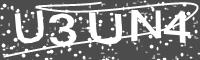

after:


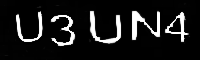

U3UN4


In [7]:
captcha = clean_captcha(request_captcha())
print re.sub('[^0-9A-Z]+', '', image_to_string(captcha).upper())